# Heritability enrichment

## Setup

In [1]:
from adjustText import adjust_text
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import scipy
from scipy.stats import combine_pvalues, pearsonr, spearmanr, mannwhitneyu
from statsmodels.stats.meta_analysis import combine_effects
import statsmodels.api as sm
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
import yaml

In [2]:
PLOT_DIR = "../../results/plots/ldsc/"
os.makedirs(PLOT_DIR, exist_ok=True)

with open("../../config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [3]:
gpn_star_top_model = config["gpn_star_top_model"]
filt_seg_tissues = config["filt_seg_tissues"]
enformer_models = config["enformer_models"]
enformer_tissue_agnostic = "cV2F_tissue_agnostic_extract_Enformer.Enformer_all_all"
seg_models = [f"filt_SEG/{gpn_star_top_model}/{tissue}" for tissue in filt_seg_tissues]
conservation_models = list(config["conservation"].keys())
gpn_star_models = [
    config["gpn_star_p"],
    config["gpn_star_m"],
    config["gpn_star_v"],
]
other_models = [
    "GPN-MSA_absLLR",
    "CADD",
]
seg_models = [f"filt_SEG/{gpn_star_top_model}/{tissue}" for tissue in filt_seg_tissues]
ablation_models = [
    "GPN-Star-p36-200M-256_minus_entropy_calibrated",
]

In [4]:
models_part1 = (
    gpn_star_models + conservation_models + [enformer_tissue_agnostic] + other_models
)
models_part1

['GPN-Star-p243-200M-256_minus_entropy_calibrated',
 'GPN-Star-m447-200M-256_minus_entropy_calibrated',
 'GPN-Star-v100-200M-128_minus_entropy_calibrated',
 'phastCons_43p',
 'phyloP_239p',
 'phyloP_447m',
 'phastCons_470m',
 'phastCons_100v',
 'phyloP_100v',
 'cV2F_tissue_agnostic_extract_Enformer.Enformer_all_all',
 'GPN-MSA_absLLR',
 'CADD']

In [5]:
models_part2 = gpn_star_models + conservation_models
models_part2

['GPN-Star-p243-200M-256_minus_entropy_calibrated',
 'GPN-Star-m447-200M-256_minus_entropy_calibrated',
 'GPN-Star-v100-200M-128_minus_entropy_calibrated',
 'phastCons_43p',
 'phyloP_239p',
 'phyloP_447m',
 'phastCons_470m',
 'phastCons_100v',
 'phyloP_100v']

In [6]:
models_part3 = [gpn_star_top_model] + seg_models + enformer_models
models_part3

['GPN-Star-p243-200M-256_minus_entropy_calibrated',
 'filt_SEG/GPN-Star-p243-200M-256_minus_entropy_calibrated/Liver',
 'filt_SEG/GPN-Star-p243-200M-256_minus_entropy_calibrated/Kidney_Cortex',
 'filt_SEG/GPN-Star-p243-200M-256_minus_entropy_calibrated/Lung',
 'filt_SEG/GPN-Star-p243-200M-256_minus_entropy_calibrated/group_blood_immune',
 'filt_SEG/GPN-Star-p243-200M-256_minus_entropy_calibrated/group_CNS',
 'filt_SEG/GPN-Star-p243-200M-256_minus_entropy_calibrated/group_digestive',
 'filt_SEG/GPN-Star-p243-200M-256_minus_entropy_calibrated/group_adipose',
 'filt_SEG/GPN-Star-p243-200M-256_minus_entropy_calibrated/group_heart',
 'filt_SEG/GPN-Star-p243-200M-256_minus_entropy_calibrated/group_skin',
 'cV2F_tissue_agnostic_extract_Enformer.Enformer_all_all',
 'cV2F_tissue_agnostic_extract_Enformer.Enformer_brain_all',
 'cV2F_tissue_agnostic_extract_Enformer.Enformer_blood_all',
 'cV2F_tissue_agnostic_extract_Enformer.Enformer_liver_all',
 'cV2F_tissue_agnostic_extract_Enformer.Enformer_g

In [7]:
models_part4 = [gpn_star_top_model] + ablation_models + ["phyloP_239p", "phastCons_43p"]

In [8]:
palette = {
    "GPN-Star (V)": "#2773BA",
    "GPN-Star (M)": "#4F97DB",
    "GPN-Star (P)": "#95BFE6",
    "GPN-MSA": "#919191",
    "CADD": "#E09D5A",
    "PhyloP (V)": "#9E66BA",
    "PhastCons (V)": "#C4494B",
    "PhyloP (M)": "#B684D9",
    "PhastCons (M)": "#D96C70",
    "PhyloP (P)": "#D4A6ED",
    "PhastCons (P)": "#EDA8A6",
    "Enformer": "#B58181",
}

palette_part4 = {
    "GPN-Star (P243)": "#95BFE6",
    "GPN-Star (P36)": "#c1d2e3",
    "PhyloP (P243)": "#D4A6ED",
    "PhastCons (P43)": "#EDA8A6",
}

model_renaming_general = {
    "GPN-Star-v100-200M-128_minus_entropy_calibrated": "GPN-Star (V)",
    "GPN-Star-m447-200M-256_minus_entropy_calibrated": "GPN-Star (M)",
    "GPN-Star-p243-200M-256_minus_entropy_calibrated": "GPN-Star (P)",
    "GPN-MSA_absLLR": "GPN-MSA",
    "CADD": "CADD",
    "phyloP_100v": "PhyloP (V)",
    "phastCons_100v": "PhastCons (V)",
    "phyloP_447m": "PhyloP (M)",
    "phastCons_470m": "PhastCons (M)",
    "phyloP_239p": "PhyloP (P)",
    "phastCons_43p": "PhastCons (P)",
    "cV2F_tissue_agnostic_extract_Enformer.Enformer_all_all": "Enformer",
}

model_renaming_part4 = {
    "GPN-Star-p243-200M-256_minus_entropy_calibrated": "GPN-Star (P243)",
    "GPN-Star-p36-200M-256_minus_entropy_calibrated": "GPN-Star (P36)",
    "phyloP_239p": "PhyloP (P243)",
    "phastCons_43p": "PhastCons (P43)",
}


gpn_star_top_model_name = model_renaming_general[gpn_star_top_model]

model_renaming_tissue_specific = {
    gpn_star_top_model: f"{gpn_star_top_model_name}-all",
    f"filt_SEG/{gpn_star_top_model}/Liver": f"{gpn_star_top_model_name}-liver",
    f"filt_SEG/{gpn_star_top_model}/Kidney_Cortex": f"{gpn_star_top_model_name}-kidney",
    f"filt_SEG/{gpn_star_top_model}/Lung": f"{gpn_star_top_model_name}-lung",
    f"filt_SEG/{gpn_star_top_model}/group_blood_immune": f"{gpn_star_top_model_name}-blood",
    f"filt_SEG/{gpn_star_top_model}/group_CNS": f"{gpn_star_top_model_name}-brain",
    f"filt_SEG/{gpn_star_top_model}/group_digestive": f"{gpn_star_top_model_name}-gut",
    f"filt_SEG/{gpn_star_top_model}/group_adipose": f"{gpn_star_top_model_name}-fat",
    f"filt_SEG/{gpn_star_top_model}/group_heart": f"{gpn_star_top_model_name}-heart",
    f"filt_SEG/{gpn_star_top_model}/group_skin": f"{gpn_star_top_model_name}-skin",
}

for model in enformer_models:
    model_renaming_tissue_specific[model] = f"Enformer-{model.split('_')[-2]}"

## Helper functions

In [9]:
def load_models(traits, models, qs, approaches, model_renaming):
    res = []
    for _, trait in tqdm(traits.iterrows(), total=len(traits)):
        trait_path = trait["File name"]
        trait_name = trait["Trait"]
        for model in models:
            for q in qs:
                for approach in approaches:
                    df = pd.read_parquet(
                        f"../../results/output/{approach}/{model}/{q}/{trait_path}.parquet"
                    )
                    df["trait"] = trait_name
                    df["model"] = model_renaming.get(model, model)
                    df["q"] = q
                    df["approach"] = approach
                    res.append(df)
    res = pd.concat(res)
    res = res.rename(columns={"tau_star_se": "tau_star_std_error"})
    return res


def combine_e(effects, variances):
    res = combine_effects(effects, variances).summary_frame().loc["random effect"]
    # testing the hypothesis effect > 0
    p_value = scipy.stats.norm.sf(res.eff / res.sd_eff)
    return res.eff, res.sd_eff, p_value


def run_meta_analysis(res):
    x = (
        res.groupby(["model", "q", "approach"])
        .apply(
            lambda df: pd.Series(
                dict(
                    **dict(
                        zip(
                            ["Enrichment", "Enrichment_sd", "Enrichment_p"],
                            combine_e(df.Enrichment, df.Enrichment_std_error**2),
                        )
                    ),
                    **dict(
                        zip(
                            ["Coefficient", "Coefficient_sd", "Coefficient_p"],
                            combine_e(df.Coefficient, df.Coefficient_std_error**2),
                        )
                    ),
                    **dict(
                        zip(
                            ["tau_star", "tau_star_sd", "tau_star_p"],
                            combine_e(df.tau_star, df.tau_star_std_error**2),
                        )
                    ),
                )
            )
        )
        .reset_index()
    )
    p_cols = [
        "Enrichment_p",
        "Coefficient_p",
        "tau_star_p",
    ]
    for col in p_cols:
        x[col + "_minuslog10"] = -np.log10(x[col])
    return x


def plot_bar_part1(df, x, xlabel, limit, save_path=None, major_locator=None):
    plt.figure(figsize=(3, 3.5))
    sns.barplot(
        data=df,
        y="model",
        x=x,
        palette=palette,
    )
    err_col = x + "_sd"
    if err_col in df.columns:
        plt.errorbar(
            x=df[x],
            y=df["model"],
            xerr=df[err_col],
            fmt="none",  # Do not connect the error bars with a line
            ecolor="black",
        )
    plt.xlabel(xlabel)
    sns.despine()
    ax = plt.gca()
    if major_locator is not None:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(major_locator))
    plt.gca().set_xlim(left=limit)
    plt.ylabel("")
    if save_path is not None:
        plt.savefig(PLOT_DIR + save_path, bbox_inches="tight")


def plot_agg_relplot(
    df, palette, x_label="q", y_label="value", values_to_plot=["Enrichment", "Tau_star"]
):
    # Melt the data into long format for metrics and their SDs
    value_vars = values_to_plot
    sd_vars = [f"{col}_sd" for col in value_vars]

    # Melt values
    value_df = df.melt(
        id_vars=["Model", "q"],
        value_vars=value_vars,
        var_name="metric",
        value_name="value",
    )

    # Melt standard deviations
    sd_df = df.melt(
        id_vars=["Model", "q"], value_vars=sd_vars, var_name="metric", value_name="sd"
    )
    sd_df["metric"] = sd_df["metric"].str.replace("_sd", "")

    # Merge values and SDs
    long_df = pd.merge(value_df, sd_df, on=["Model", "q", "metric"])

    # Sort each metric's data by value in descending order (as in original code)
    # long_df = long_df.groupby('metric', group_keys=False).apply(
    #    lambda x: x.sort_values('value', ascending=False)
    # )
    long_df = long_df.sort_values("value", ascending=False)

    # Create relplot
    g = sns.relplot(
        data=long_df,
        x="q",
        y="value",
        hue="Model",
        # row='metric',
        kind="line",
        marker="o",
        palette=palette,
        facet_kws={"sharex": True, "sharey": False},
        height=3,
        aspect=1.1,
        errorbar=None,
        # legend=False
        linewidth=1,  # <-- thinner lines
        markersize=5,  # <-- smaller markers
    )

    # Add custom error bars to each subplot
    metrics = long_df["metric"].unique()
    for i, ax in enumerate(g.axes.flat):
        current_metric = metrics[i]
        subset = long_df[long_df["metric"] == current_metric]

        for model in subset["Model"].unique():
            model_data = subset[subset["Model"] == model]
            color = palette[model]
            ax.errorbar(
                x=model_data["q"],
                y=model_data["value"],
                yerr=model_data["sd"],
                color=color,
                fmt="none",
                linewidth=1,
            )

        # Set y-axis limits
        if current_metric == "Enrichment":
            ax.set_ylim(bottom=1)
        elif current_metric == "Tau_star":
            ax.set_ylim(bottom=0)
        ax.set_xlim(right=long_df.q.max() + 0.001)

    g.set_axis_labels(x_label, y_label)

    # Despine and adjust layout
    sns.despine()

## Load traits

In [10]:
trait_tissues = pd.read_csv("../../config/trait_tissues.tsv", sep="\t", index_col=0)
trait_tissues = trait_tissues.astype(bool)
trait_tissues = trait_tissues[trait_tissues.index != "Multiple Sclerosis"]
trait_tissues.rename(columns={"blood/immune": "blood"}, inplace=True)
trait_tissues

,brain,blood,fat,gut,heart,kidney,liver,lung,skin
Trait,,,,,,,,,
Schizophrenia,True,False,False,False,False,False,False,False,False
Depression,True,False,False,False,False,False,False,False,False
Bipolar disorder (all cases),True,False,False,False,False,False,False,False,False
KneeOA,False,False,True,False,False,False,False,False,False
COPD,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...
Cannabis use disorder,True,False,False,False,False,False,False,False,False
Telomere Length,False,False,False,False,False,False,False,False,False
Ever Smoked,True,False,False,False,False,False,False,False,False


In [11]:
trait_tissues.index.value_counts()

Trait
Prostate Cancer                2
Testosterone Male              1
Number Children Ever Born      1
Rbc Distribution Width         1
Aging Parental Lifespan        1
                              ..
Endometriosis                  1
Inguinal Hernia                1
Alzheimer’s disease            1
Mouth Teeth Dental Problems    1
Breast Cancer (female)         1
Name: count, Length: 105, dtype: int64

In [12]:
trait_tissues.loc["Prostate Cancer"]

,brain,blood,fat,gut,heart,kidney,liver,lung,skin
Trait,,,,,,,,,
Prostate Cancer,False,False,False,False,False,False,False,False,False
Prostate Cancer,False,False,False,False,False,False,False,False,False


In [13]:
counts = trait_tissues.groupby(trait_tissues.index).cumcount()
# 2. Define the new index using np.where
#    If count > 0, append '_count'; otherwise, keep the original index label.
trait_tissues.index = np.where(
    counts > 0, trait_tissues.index + "_" + counts.astype(str), trait_tissues.index
)

In [14]:
trait_tissues.index.value_counts()

CHIP                   1
Schizophrenia          1
Cholesterol            1
Alcohol use/AUDIT      1
Total Bilirubin        1
                      ..
Asthma                 1
ADHD                   1
Atrial Fibrillation    1
Glaucoma               1
Insomnia               1
Name: count, Length: 106, dtype: int64

In [15]:
trait_tissues[trait_tissues.index.str.contains("Prostate Cancer")]

,brain,blood,fat,gut,heart,kidney,liver,lung,skin
Prostate Cancer,False,False,False,False,False,False,False,False,False
Prostate Cancer_1,False,False,False,False,False,False,False,False,False


In [16]:
trait_tissues.sum(axis=0).sort_values(ascending=False)

brain     30
blood     15
liver     15
gut       13
kidney     9
fat        8
heart      7
skin       7
lung       6
dtype: int64

In [17]:
tissue_order = (
    trait_tissues.sum(axis=0).sort_values(ascending=False).index.values.tolist()
)
tissue_order

['brain', 'blood', 'liver', 'gut', 'kidney', 'fat', 'heart', 'skin', 'lung']

In [18]:
tissue_traits = {
    tissue: set(trait_tissues[trait_tissues[tissue]].index)
    for tissue in trait_tissues.columns
}

In [19]:
traits = pd.read_csv("../../config/traits_indep107.tsv", sep="\t")
# this one requires submitting an application first
traits = traits[traits["File name"] != "PASS.Multiple_Sclerosis.IMSGC2019"]
traits.loc[traits["File name"] == "UKB_460K.cancer_PROSTATE", "Trait"] = (
    "Prostate Cancer_1"
)
traits

,Trait,File name,Paper Link,Mean N,h2 Z,Unnamed: 5
0,Schizophrenia,PASS.Schizophrenia.Trubetskoy2022,https://www.nature.com/articles/s41586-022-044...,58572,28.30,NaN
1,Depression,PASS.Depression.Howard2019,https://www.nature.com/articles/s41593-018-032...,500199,24.12,NaN
2,Bipolar disorder (all cases),PASS.Bipolar_Disorder_ALL.Mullins2021,https://www.nature.com/articles/s41588-021-008...,405675,23.53,NaN
3,KneeOA,PASS.Knee_Osteoarthritis.Boer2021,https://www.cell.com/cell/fulltext/S0092-8674(...,395571,22.30,NaN
4,COPD,PASS.Chronic_Obstructive_Pulmonary_Disease.Con...,https://www.medrxiv.org/content/10.1101/2022.0...,325027,21.10,NaN
...,...,...,...,...,...,...
102,Cannabis use disorder,PASS.Cannabis_Use_Disorder.Johnson2020,https://www.thelancet.com/journals/lanpsy/arti...,359934,8.57,NaN
103,Telomere Lenght,PASS.Telomere_Length.Codd2021,https://www.nature.com/articles/s41588-021-009...,472174,8.32,NaN
104,Ever Smoked,PASS.Ever_Smoked.TAGC2010,https://www.nature.com/articles/ng.571,74035,7.54,NaN
105,Structural Connectivity Global (imaging),PASS.Structural_Connectivity_Global.Tissink2023,https://www.eneuro.org/content/10/4/ENEURO.024...,22720,7.44,NaN


In [20]:
traits.Trait.value_counts()

Trait
CHIP                   1
Schizophrenia          1
Cholesterol            1
Alcohol use/AUDIT      1
Total Bilirubin        1
                      ..
Asthma                 1
ADHD                   1
Atrial Fibrillation    1
Glaucoma               1
Insomnia               1
Name: count, Length: 106, dtype: int64

## Part 1 (main analysis)

In [21]:
plt.rcParams["font.size"] = 12  # TODO: maybe save the defaults somewhere?

In [22]:
res = load_models(
    traits,
    models_part1,
    [0.001],
    ["quantile", "quantile_CDS", "quantile_nonCDS"],
    model_renaming_general,
)
res.head()

100%|██████████| 106/106 [00:19<00:00,  5.35it/s]


,Category,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,Coefficient_std_error,Coefficient_z-score,tau_star,tau_star_std_error,trait,model,q,approach
0,L2_1,0.001,0.028991,0.006610,28.991937,6.609759,0.000027,0.000003,9.423354e-07,3.668543,0.235624,0.064228,Schizophrenia,GPN-Star (P),0.001,quantile
0,L2_1,0.001,0.013357,0.005626,13.357119,5.626125,0.027105,0.000002,8.519755e-07,2.361718,0.153374,0.064942,Schizophrenia,GPN-Star (P),0.001,quantile_CDS
0,L2_1,0.001,0.038190,0.007577,38.190740,7.576743,0.000002,0.000004,1.060385e-06,4.067945,0.276117,0.067876,Schizophrenia,GPN-Star (P),0.001,quantile_nonCDS
0,L2_1,0.001,0.021400,0.006490,21.400080,6.490133,0.001739,0.000002,9.176335e-07,2.522513,0.156757,0.062143,Schizophrenia,GPN-Star (M),0.001,quantile
0,L2_1,0.001,0.011257,0.005951,11.257640,5.950902,0.084715,0.000002,9.572546e-07,1.928360,0.140255,0.072733,Schizophrenia,GPN-Star (M),0.001,quantile_CDS


In [23]:
res.model.value_counts()

model
GPN-Star (P)     318
GPN-Star (M)     318
GPN-Star (V)     318
PhastCons (P)    318
PhyloP (P)       318
PhyloP (M)       318
PhastCons (M)    318
PhastCons (V)    318
PhyloP (V)       318
Enformer         318
GPN-MSA          318
CADD             318
Name: count, dtype: int64

In [24]:
agg_res = run_meta_analysis(res)
agg_res.head()

,model,q,approach,Enrichment,Enrichment_sd,Enrichment_p,Coefficient,Coefficient_sd,Coefficient_p,tau_star,tau_star_sd,tau_star_p,Enrichment_p_minuslog10,Coefficient_p_minuslog10,tau_star_p_minuslog10
0,CADD,0.001,quantile,16.654385,1.299988,7.097446e-38,6.805951e-08,1.722424e-08,0.000039,0.063960,0.011637,1.938162e-08,37.148898,4.410597,7.712610
1,CADD,0.001,quantile_CDS,13.827831,1.489106,8.010225e-21,7.820144e-08,2.844465e-08,0.002987,0.066964,0.015852,1.198364e-05,20.096355,2.524823,4.921411
2,CADD,0.001,quantile_nonCDS,10.950864,1.404902,3.226792e-15,1.225769e-08,1.202424e-08,0.154003,0.011242,0.009999,1.304385e-01,14.491229,0.812471,0.884594
3,Enformer,0.001,quantile,4.460529,1.128803,3.882217e-05,3.345269e-09,7.699216e-09,0.331965,0.004307,0.007476,2.822702e-01,4.410920,0.478908,0.549335
4,Enformer,0.001,quantile_CDS,3.304821,1.135860,1.809859e-03,-1.486131e-08,7.261450e-09,0.979651,-0.024209,0.009899,9.927674e-01,2.742355,0.008928,0.003152


### Panel A

In [25]:
df = agg_res[(agg_res.approach == "quantile") & (agg_res.q == 0.001)]
df = df.sort_values("Enrichment", ascending=False)
df[["model", "Enrichment", "tau_star"]]

,model,Enrichment,tau_star
12,GPN-Star (P),40.147149,0.286471
9,GPN-Star (M),35.783026,0.245022
21,PhastCons (P),22.916398,0.114043
15,GPN-Star (V),20.132238,0.094747
6,GPN-MSA,16.688845,0.056007
0,CADD,16.654385,0.063960
27,PhyloP (M),12.127203,0.034485
18,PhastCons (M),10.344203,0.028150
33,PhyloP (V),9.382104,0.020853
24,PhastCons (V),7.076362,-0.004798


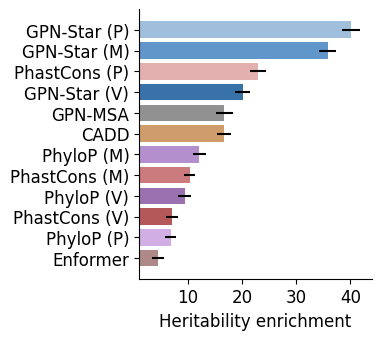

In [26]:
plot_bar_part1(
    df,
    "Enrichment",
    "Heritability enrichment",
    1,
    "fig3_h2_enrich_full.svg",
    major_locator=10,
)

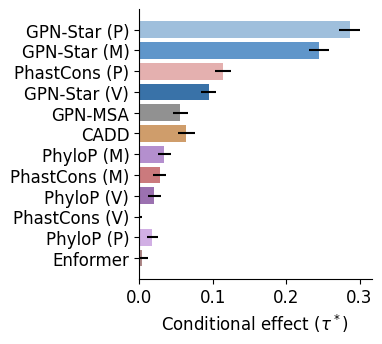

In [27]:
plot_bar_part1(
    df, "tau_star", "Conditional effect " + r"$(\tau^*)$", 0, "fig3_tau_est_full.svg"
)

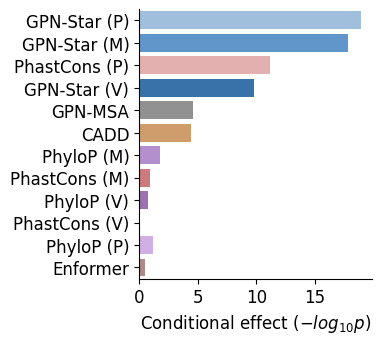

In [28]:
# FIXME: Should this be on Coefficient or Tau p-value?
plot_bar_part1(
    df,
    "Coefficient_p_minuslog10",
    "Conditional effect " + r"$(-log_{10}p)$",
    0,
    "fig3_tau_p_full.svg",
)

### Panel B

In [29]:
df = agg_res[(agg_res.approach == "quantile_CDS") & (agg_res.q == 0.001)]
df = df.sort_values("Enrichment", ascending=False)
df[["model", "Enrichment", "tau_star"]]

,model,Enrichment,tau_star
10,GPN-Star (M),18.776714,0.123762
13,GPN-Star (P),18.288231,0.109349
28,PhyloP (M),15.576480,0.086664
19,PhastCons (M),14.854137,0.073890
7,GPN-MSA,13.986127,0.054986
1,CADD,13.827831,0.066964
16,GPN-Star (V),13.709017,0.054769
34,PhyloP (V),13.431821,0.060806
31,PhyloP (P),11.659260,0.043940
25,PhastCons (V),11.414554,0.034722


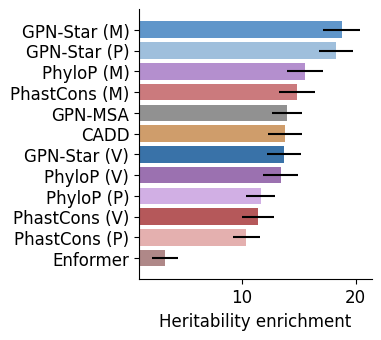

In [30]:
plot_bar_part1(
    df,
    "Enrichment",
    "Heritability enrichment",
    1,
    "fig3_h2_enrich_cds.svg",
    major_locator=10,
)

### Panel C

In [31]:
df = agg_res[(agg_res.approach == "quantile_nonCDS") & (agg_res.q == 0.001)]
df = df.sort_values("Enrichment", ascending=False)
df[["model", "Enrichment", "tau_star"]]

,model,Enrichment,tau_star
14,GPN-Star (P),36.047320,0.233135
11,GPN-Star (M),33.179304,0.211987
23,PhastCons (P),23.622669,0.117751
17,GPN-Star (V),15.231633,0.048869
8,GPN-MSA,11.984280,0.023864
2,CADD,10.950864,0.011242
29,PhyloP (M),8.337287,0.012062
32,PhyloP (P),7.163882,0.021627
20,PhastCons (M),6.957979,0.001766
35,PhyloP (V),6.299512,0.000148


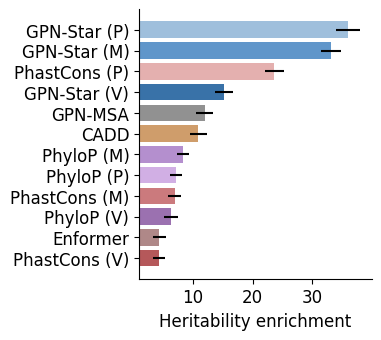

In [32]:
plot_bar_part1(
    df,
    "Enrichment",
    "Heritability enrichment",
    1,
    "fig3_h2_enrich_noncds.svg",
    major_locator=10,
)

### TODO: Top 20 traits

In [33]:
top_heritable_traits = (
    traits.sort_values("h2 Z", ascending=False).Trait.iloc[:20].values
)
top_heritable_traits

array(['BMI', 'COPD - FVC', 'Intelligence', 'Schizophrenia',
       'Diastolic (Blood Pressure)', 'Daytime napping', 'Wbc Count',
       'Height', 'Morning Person', 'Menarche Age', 'Total Protein',
       'Depression', 'WHR BMI ratio', 'Bipolar disorder (all cases)',
       'Reaction Time', 'KneeOA', 'Creatinine', 'Snoring', 'Rbc Count',
       'Fetal Birth Weight'], dtype=object)

In [34]:
df = res[
    (res.approach == "quantile")
    & (res.q == 0.001)
    & (res.trait.isin(top_heritable_traits))
]
df.head()

,Category,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,Coefficient_std_error,Coefficient_z-score,tau_star,tau_star_std_error,trait,model,q,approach
0,L2_1,0.001,0.028991,0.006610,28.991937,6.609759,0.000027,3.456998e-06,9.423354e-07,3.668543,0.235624,0.064228,Schizophrenia,GPN-Star (P),0.001,quantile
0,L2_1,0.001,0.021400,0.006490,21.400080,6.490133,0.001739,2.314743e-06,9.176335e-07,2.522513,0.156757,0.062143,Schizophrenia,GPN-Star (M),0.001,quantile
0,L2_1,0.001,0.010319,0.006439,10.319251,6.439654,0.149134,5.551782e-07,9.166006e-07,0.605693,0.037486,0.061890,Schizophrenia,GPN-Star (V),0.001,quantile
0,L2_1,0.001,0.026142,0.008354,26.142958,8.353783,0.002870,2.557788e-06,1.156203e-06,2.212232,0.160716,0.072649,Schizophrenia,PhastCons (P),0.001,quantile
0,L2_1,0.001,0.009773,0.006365,9.773122,6.365038,0.172730,8.014429e-07,8.975266e-07,0.892946,0.045571,0.051035,Schizophrenia,PhyloP (P),0.001,quantile


### Polygenicity

In [35]:
polygenicity = pd.read_csv("../../config/polygenicity.tsv", sep="\t")
polygenicity.trait = polygenicity.trait.replace(
    {
        "General risk tolerance": "General Risk Tolerance",
        "Bipolar disorder": "Bipolar disorder (all cases)",
        "Years of education": "Education Years",
        "Chronotype (morning person)": "Morning Person",
        "Body mass index": "BMI",
        "Reported drinks per week": "Drinks Per Week",
        "Sleep duration": "Sleep Duration",
        "Reaction time": "Reaction Time",
        "Age at menarche": "Menarche Age",
        "Creatinine level": "Creatinine",
        "Blood pressure - diastolic": "Diastolic (Blood Pressure)",
        "Atrial fibrillation": "Atrial Fibrillation",
        "Waist-hip ratio (corrected for BMI)": "WHR BMI ratio",  # doesn't seem correct actually
        "IGF1 level in blood": "IGF1",
        "Alzheimer's disease": "Alzheimer’s disease",
        "Phosphate levels": "Phosphate",
        "Total protein level in blood": "Total Protein",
        "Aspartate aminotransferase level": "Aspartate Aminotransferase",
        "Hypothyroidism": "Hypothyroidism (Self reported)",  # matches sample size
        "Coronary artery disease": "Coronary Artery Disease (Aragam)",
        "Breast cancer": "Breast Cancer (female)",
        "Inflammatory bowel disease": "IBD",
        "Red blood cell count": "Rbc Count",
    }
)
polygenicity

,trait,path,polygenicity_entropy,polygenicity_effective,polygenicity_softmax,polygenicity_entropy_se,polygenicity_effective_se,polygenicity_softmax_se
0,BMI,PASS.BMI.Yengo2018,4.717155,3.584002,2.374818,0.042865,0.100939,5.147770e-04
1,Education Years,UKB_460K.cov_EDU_YEARS,4.766821,3.944341,2.602199,0.055153,0.152843,5.888508e-04
2,FVC (corrected for smoking),UKB_460K.lung_FVCzSMOKE,4.768843,3.835271,2.582138,0.026630,0.089552,3.439298e-04
3,Neuroticism,UKB_460K.mental_NEUROTICISM,4.676895,3.970830,2.670512,0.053029,0.148490,5.512177e-04
4,Diastolic (Blood Pressure),UKB_460K.bp_DIASTOLICadjMEDz,4.423655,3.708486,2.199882,0.054360,0.227853,3.076291e-03
5,Height,PASS.Height.Yengo2022,4.316627,3.793203,1.988235,0.045268,0.426699,1.722114e-02
6,Morning Person,UKB_460K.other_MORNINGPERSON,4.732653,3.979375,2.631490,0.068927,0.208584,1.040437e-03
7,Menarche Age,UKB_460K.repro_MENARCHE_AGE,4.572528,3.344030,2.056358,0.061399,0.178762,2.039829e-03
8,Total Protein,UKB_460K.biochemistry_TotalProtein,4.111995,3.590240,1.790085,0.073896,0.561932,1.933649e-01
9,WHR BMI ratio,UKB_460K.body_WHRadjBMIz,4.327440,3.429549,2.029742,0.053708,0.214082,3.271554e-03


In [36]:
def quantify_gaussian_difference(mu_A, sigma_A, mu_B, sigma_B):
    """
    Calculates and prints three metrics to quantify how "larger"
    Gaussian A is than Gaussian B.

    Args:
        mu_A (float): Mean of Gaussian A.
        sigma_A (float): Standard deviation of Gaussian A.
        mu_B (float): Mean of Gaussian B.
        sigma_B (float): Standard deviation of Gaussian B.
    """
    # --- 1. Difference in Means ---
    mean_diff = mu_A - mu_B

    mean_diff_sign = np.sign(mean_diff)

    # --- 2. Standardized Mean Difference ---
    # The denominator is the standard deviation of the difference distribution (A - B)
    pooled_std_dev = np.sqrt(sigma_A**2 + sigma_B**2)
    smd = (mu_A - mu_B) / pooled_std_dev

    # --- 3. Probability of Superiority (CLES) ---
    # This is P(A > B), calculated using the standard normal CDF (Phi)
    prob_sup = scipy.stats.norm.cdf(smd)

    return dict(
        mean_diff=mean_diff, mean_diff_sign=mean_diff_sign, smd=smd, prob_sup=prob_sup
    )


def primate_specificity(rows):
    p_row = rows[rows.model == "GPN-Star (P)"]
    assert len(p_row) == 1
    p_row = p_row.iloc[0]
    m_row = rows[rows.model == "GPN-Star (M)"]
    assert len(m_row) == 1
    m_row = m_row.iloc[0]

    col = "Enrichment"
    # col = "Coefficient"
    # col = "tau_star"

    return pd.Series(
        quantify_gaussian_difference(
            p_row[col], p_row[f"{col}_std_error"], m_row[col], m_row[f"{col}_std_error"]
        )
    )


df = (
    res[(res.approach == "quantile") & (res.q == 0.001)]
    .groupby("trait")
    .apply(primate_specificity)
    .reset_index()
)
df = (
    df.merge(polygenicity, how="inner", on="trait")
    .sort_values("polygenicity_effective", ascending=False)
    .reset_index(drop=True)
)
print(len(df))
df

27


,trait,mean_diff,mean_diff_sign,smd,prob_sup,path,polygenicity_entropy,polygenicity_effective,polygenicity_softmax,polygenicity_entropy_se,polygenicity_effective_se,polygenicity_softmax_se
0,Drinks Per Week,22.904005,1.0,0.747445,0.772602,PASS_DrinksPerWeek_Liu2019,4.713836,4.259151,2.496746,0.063183,0.238213,1.913442e-03
1,Reaction Time,17.524536,1.0,1.317275,0.906127,PASS_ReactionTime_Davies2018,4.609981,4.136210,2.490256,0.093348,0.412268,2.621523e-03
2,General Risk Tolerance,2.591140,1.0,0.196251,0.577793,PASS_GeneralRiskTolerance_KarlssonLinner2019,4.911217,4.117506,2.770456,0.127297,0.110653,1.350000e-14
3,Schizophrenia,7.591857,1.0,0.819553,0.793765,PASS_Schizophrenia_Pardinas2018,4.741281,4.116248,2.672628,0.033424,0.104704,4.289500e-04
4,Sleep Duration,5.057049,1.0,0.338788,0.632615,PASS_SleepDuration_Dashti2019,4.664294,4.028326,2.547535,0.061766,0.308685,1.590053e-03
5,Morning Person,21.138464,1.0,2.027063,0.978672,UKB_460K.other_MORNINGPERSON,4.732653,3.979375,2.631490,0.068927,0.208584,1.040437e-03
6,Insomnia,-13.824438,-1.0,-0.811083,0.208659,PASS.Insomnia.Watanabe2022,4.819354,3.966771,2.770456,0.384649,0.240670,1.340000e-14
7,Bipolar disorder (all cases),6.249892,1.0,0.511478,0.695492,PASS.Bipolar_Disorder_ALL.Mullins2021,4.790402,3.953114,2.674011,0.149945,0.292829,9.556146e-04
8,Education Years,19.491143,1.0,0.733127,0.768260,UKB_460K.cov_EDU_YEARS,4.766821,3.944341,2.602199,0.055153,0.152843,5.888508e-04
9,Height,18.200525,1.0,1.082707,0.860531,PASS.Height.Yengo2022,4.316627,3.793203,1.988235,0.045268,0.426699,1.722114e-02


In [37]:
df.corr(numeric_only=True)

,mean_diff,mean_diff_sign,smd,prob_sup,polygenicity_entropy,polygenicity_effective,polygenicity_softmax,polygenicity_entropy_se,polygenicity_effective_se,polygenicity_softmax_se
mean_diff,1.000000,0.811086,0.915210,0.938580,0.364795,0.465910,0.359679,-0.589010,-0.120840,-0.185244
mean_diff_sign,0.811086,1.000000,0.789920,0.862049,0.430883,0.522925,0.385897,-0.526163,-0.099781,-0.296958
smd,0.915210,0.789920,1.000000,0.980083,0.347961,0.431247,0.351483,-0.537219,-0.024085,-0.137101
prob_sup,0.938580,0.862049,0.980083,1.000000,0.353803,0.437960,0.345279,-0.578304,-0.034388,-0.146448
polygenicity_entropy,0.364795,0.430883,0.347961,0.353803,1.000000,0.883450,0.848579,-0.112667,-0.289200,-0.779222
polygenicity_effective,0.465910,0.522925,0.431247,0.437960,0.883450,1.000000,0.818987,-0.227507,-0.259911,-0.617473
polygenicity_softmax,0.359679,0.385897,0.351483,0.345279,0.848579,0.818987,1.000000,-0.026976,-0.441198,-0.426164
polygenicity_entropy_se,-0.589010,-0.526163,-0.537219,-0.578304,-0.112667,-0.227507,-0.026976,1.000000,0.236361,0.173960
polygenicity_effective_se,-0.120840,-0.099781,-0.024085,-0.034388,-0.289200,-0.259911,-0.441198,0.236361,1.000000,0.207307
polygenicity_softmax_se,-0.185244,-0.296958,-0.137101,-0.146448,-0.779222,-0.617473,-0.426164,0.173960,0.207307,1.000000


In [38]:
df.corr(numeric_only=True, method="spearman")

,mean_diff,mean_diff_sign,smd,prob_sup,polygenicity_entropy,polygenicity_effective,polygenicity_softmax,polygenicity_entropy_se,polygenicity_effective_se,polygenicity_softmax_se
mean_diff,1.000000,0.791438,0.924908,0.924908,0.305250,0.460928,0.366356,-0.489011,-0.178266,-0.213065
mean_diff_sign,0.791438,1.000000,0.791438,0.791438,0.354064,0.510269,0.411402,-0.416546,-0.114550,-0.229100
smd,0.924908,0.791438,1.000000,1.000000,0.301587,0.454823,0.356587,-0.445055,-0.054335,-0.150794
prob_sup,0.924908,0.791438,1.000000,1.000000,0.301587,0.454823,0.356587,-0.445055,-0.054335,-0.150794
polygenicity_entropy,0.305250,0.354064,0.301587,0.301587,1.000000,0.811355,0.951000,-0.209402,-0.368132,-0.899267
polygenicity_effective,0.460928,0.510269,0.454823,0.454823,0.811355,1.000000,0.851168,-0.355311,-0.302198,-0.641026
polygenicity_softmax,0.366356,0.411402,0.356587,0.356587,0.951000,0.851168,1.000000,-0.248512,-0.420699,-0.903374
polygenicity_entropy_se,-0.489011,-0.416546,-0.445055,-0.445055,-0.209402,-0.355311,-0.248512,1.000000,0.479853,0.231990
polygenicity_effective_se,-0.178266,-0.114550,-0.054335,-0.054335,-0.368132,-0.302198,-0.420699,0.479853,1.000000,0.550672
polygenicity_softmax_se,-0.213065,-0.229100,-0.150794,-0.150794,-0.899267,-0.641026,-0.903374,0.231990,0.550672,1.000000


In [39]:
mean_diff_col = "Enr(Primates) - Enr(Mammals)"
poly_col = "log_10 (effective polygenicity)"
df[mean_diff_col] = df.mean_diff
df[poly_col] = df.polygenicity_effective

In [40]:
df["trait2"] = df.trait.replace(
    {
        "Drinks Per Week": "Drinks per week",
        "Bipolar disorder (all cases)": "Bipolar disorder",
        "Breast Cancer (female)": "Breast Cancer",
        "General Risk Tolerance": "Risk tolerance",
        "Education Years": "Edu years",
        "Diastolic (Blood Pressure)": "Blood pressure",
        "Total Protein": "Protein",
        "Atrial Fibrillation": "AFib",
        "Hypothyroidism (Self reported)": "Hypothyroidism",
        "Coronary Artery Disease (Aragam)": "Coronary Artery Disease",
        "Alzheimer’s disease": "Alzheimer's",
    }
)

In [41]:
from matplotlib.ticker import MultipleLocator


def fit_regression_given_logx(
    df,
    x_col,
    y_col,
    label_col=None,
    label_subset=None,
    xlabel=None,
    ylabel=None,
    figsize=2.3,
    save_path=None,
):
    """
    Assumes x_col is already log10-transformed.
    Fits a lin-lin regression (y ~ x_log) and plots the result
    by converting x_log back to a linear scale for plotting on a log-axis.
    """
    # --- 1. Prepare Data for Regression ---
    # The x-column is already logged, so we use it directly.
    y = df[y_col]
    X = sm.add_constant(df[x_col])

    # --- 2. Correlation and Model Fitting ---
    # The relationship is linear between y and the given x_col
    stat, pvalue = pearsonr(df[x_col], df[y_col], alternative="greater")
    print(f"Pearson r: {stat:.4f}, p-value: {pvalue:.4g}")

    ols_model = sm.OLS(y, X).fit()
    print(ols_model.summary())

    # --- 3. Plotting ---
    plt.figure(figsize=(figsize, figsize))

    # ✨ Exponentiate the x-column to convert it back to a linear scale for plotting.
    # Matplotlib's log scale needs the actual values (e.g., 100), not the exponent (e.g., 2).
    plt.plot(10 ** df[x_col], y, "o")

    # Set the x-axis to a logarithmic scale
    plt.xscale("log")

    # --- 4. Generate and Plot the Regression Line ---
    # Create a line of x-values IN LOG SPACE (since this is what the model uses)
    x_line_log = np.linspace(df[x_col].min() * 0.98, df[x_col].max() * 1.02, 100)

    # Predict y-values using the model
    y_line = ols_model.predict(sm.add_constant(x_line_log))

    # Plot the regression line by converting the log-space x-values back to linear space
    plt.plot(10**x_line_log, y_line, "--", color="black", linewidth=1)

    # --- 5. Formatting and Labels ---
    if label_col:
        texts = []
        for i, row in df.iterrows():
            if label_subset is None or row[label_col] in label_subset:
                # Use exponentiated x-value for label positioning
                texts.append(
                    plt.text(10 ** row[x_col], row[y_col], row[label_col], fontsize=8)
                )
        if texts:
            adjust_text(
                texts,
                # expand_points=(1.5, 1.5),
                # arrowprops=dict(arrowstyle="-", color='gray', lw=1),
            )

    ax = plt.gca()  # Get current axes
    ax.yaxis.set_major_locator(MultipleLocator(10))

    plt.title(rf"$r=${stat:.2f}, $p=${pvalue:.2g}", fontsize=10)
    plt.xlabel(xlabel if xlabel is not None else x_col)
    plt.ylabel(ylabel if ylabel is not None else y_col)
    sns.despine()
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(PLOT_DIR + save_path, bbox_inches="tight")

In [42]:
default_font_size = 10
plt.rcParams["font.size"] = default_font_size

Pearson r: 0.4659, p-value: 0.007156
                                 OLS Regression Results                                 
Dep. Variable:     Enr(Primates) - Enr(Mammals)   R-squared:                       0.217
Model:                                      OLS   Adj. R-squared:                  0.186
Method:                           Least Squares   F-statistic:                     6.931
Date:                          Mon, 15 Sep 2025   Prob (F-statistic):             0.0143
Time:                                  21:12:02   Log-Likelihood:                -97.630
No. Observations:                            27   AIC:                             199.3
Df Residuals:                                25   BIC:                             201.9
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                                      coef    std err          t      P>|

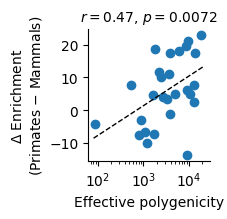

In [43]:
fit_regression_given_logx(
    df,
    poly_col,
    mean_diff_col,
    xlabel="Effective polygenicity",
    ylabel=r"$\Delta$ Enrichment" + "\n" + r"(Primates $-$ Mammals)",
    save_path="polygenicity_main.svg",
)

Pearson r: 0.4659, p-value: 0.007156
                                 OLS Regression Results                                 
Dep. Variable:     Enr(Primates) - Enr(Mammals)   R-squared:                       0.217
Model:                                      OLS   Adj. R-squared:                  0.186
Method:                           Least Squares   F-statistic:                     6.931
Date:                          Mon, 15 Sep 2025   Prob (F-statistic):             0.0143
Time:                                  21:12:03   Log-Likelihood:                -97.630
No. Observations:                            27   AIC:                             199.3
Df Residuals:                                25   BIC:                             201.9
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                                      coef    std err          t      P>|

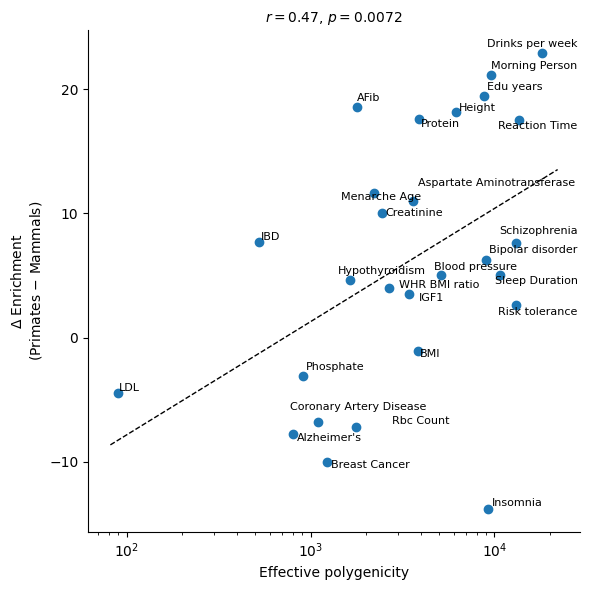

In [44]:
fit_regression_given_logx(
    df,
    poly_col,
    mean_diff_col,
    xlabel="Effective polygenicity",
    ylabel=r"$\Delta$ Enrichment" + "\n" + r"(Primates $-$ Mammals)",
    label_col="trait2",
    figsize=6,
    save_path="polygenicity_supp.pdf",
)

## Part 2 (varying quantiles)

In [45]:
plt.rcParams["font.size"] = 12

In [46]:
res = load_models(
    traits, models_part2, config["quantiles"], ["quantile"], model_renaming_general
)
res.head()

100%|██████████| 106/106 [00:46<00:00,  2.27it/s]


,Category,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,Coefficient_std_error,Coefficient_z-score,tau_star,tau_star_std_error,trait,model,q,approach
0,L2_1,0.001,0.028991,0.006610,28.991937,6.609759,0.000027,3.456998e-06,9.423354e-07,3.668543,0.235624,0.064228,Schizophrenia,GPN-Star (P),0.001,quantile
0,L2_1,0.005,0.071546,0.017769,14.309555,3.553885,0.000241,1.267090e-06,5.373023e-07,2.358243,0.184553,0.078259,Schizophrenia,GPN-Star (P),0.005,quantile
0,L2_1,0.010,0.119548,0.024636,11.954882,2.463604,0.000014,1.028665e-06,3.751196e-07,2.742231,0.206675,0.075367,Schizophrenia,GPN-Star (P),0.010,quantile
0,L2_1,0.015,0.160364,0.029222,10.691005,1.948160,0.000001,9.270646e-07,3.010913e-07,3.079014,0.223338,0.072536,Schizophrenia,GPN-Star (P),0.015,quantile
0,L2_1,0.020,0.179633,0.032279,8.981662,1.613945,0.000002,6.876572e-07,2.648119e-07,2.596776,0.187816,0.072327,Schizophrenia,GPN-Star (P),0.020,quantile


In [47]:
res.model.value_counts()

model
GPN-Star (P)     1166
GPN-Star (M)     1166
GPN-Star (V)     1166
PhastCons (P)    1166
PhyloP (P)       1166
PhyloP (M)       1166
PhastCons (M)    1166
PhastCons (V)    1166
PhyloP (V)       1166
Name: count, dtype: int64

In [48]:
agg_res = run_meta_analysis(res).sort_values("Enrichment", ascending=False)
agg_res["Model"] = agg_res.model
agg_res["Heritability enrichment"] = agg_res["Enrichment"]
agg_res["Heritability enrichment_sd"] = agg_res["Enrichment_sd"]
agg_res.head()

,model,q,approach,Enrichment,Enrichment_sd,Enrichment_p,Coefficient,Coefficient_sd,Coefficient_p,tau_star,tau_star_sd,tau_star_p,Enrichment_p_minuslog10,Coefficient_p_minuslog10,tau_star_p_minuslog10,Model,Heritability enrichment,Heritability enrichment_sd
11,GPN-Star (P),0.001,quantile,40.147149,1.684172,6.756710e-126,5.131921e-07,5.710067e-08,1.264641e-19,0.286471,0.014219,1.445461e-90,125.170265,18.898033,89.839993,GPN-Star (P),40.147149,1.684172
0,GPN-Star (M),0.001,quantile,35.783026,1.592531,4.146473e-112,4.157109e-07,4.774058e-08,1.550445e-18,0.245022,0.013701,7.898763e-72,111.382321,17.809544,71.102441,GPN-Star (M),35.783026,1.592531
12,GPN-Star (P),0.005,quantile,23.527657,0.830849,1.049228e-176,2.965286e-07,3.022531e-08,5.067954e-23,0.356193,0.017253,5.424626e-95,175.979130,22.295167,94.265630,GPN-Star (P),23.527657,0.830849
44,PhastCons (P),0.001,quantile,22.916398,1.518502,9.217647e-52,1.488102e-07,2.202279e-08,7.039027e-12,0.114043,0.011333,4.038088e-24,51.035380,11.152487,23.393824,PhastCons (P),22.916398,1.518502
1,GPN-Star (M),0.005,quantile,21.091641,0.903456,7.654210e-121,2.621550e-07,3.196590e-08,1.191127e-16,0.317359,0.019834,6.307937e-58,120.116100,15.924042,57.200113,GPN-Star (M),21.091641,0.903456


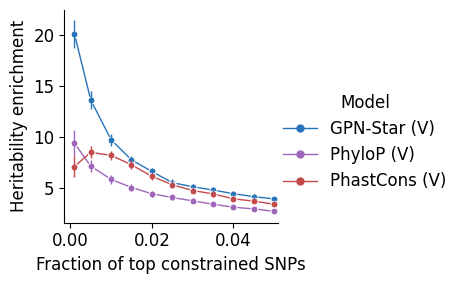

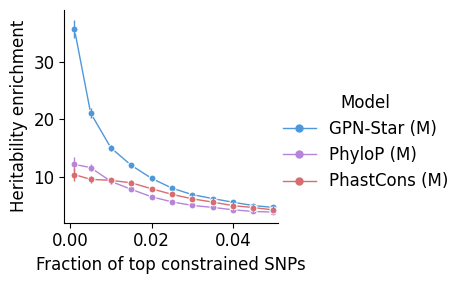

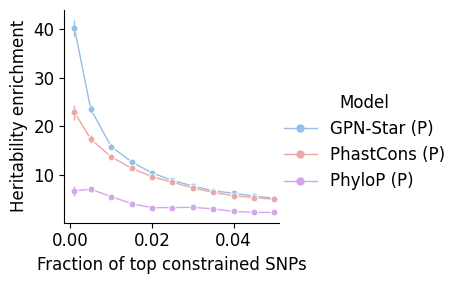

In [49]:
for timescale in ["V", "M", "P"]:
    plot_agg_relplot(
        agg_res[agg_res.model.str.endswith(f"({timescale})")],
        palette=palette,
        x_label="Fraction of top constrained SNPs",
        y_label="Heritability enrichment",
        values_to_plot=["Heritability enrichment"],
    )
    plt.savefig(
        PLOT_DIR + f"fig3_h2_enrich_top0.05_{timescale}.svg", bbox_inches="tight"
    )

## Part 3 (tissue-specific analysis)

In [50]:
res = load_models(
    traits, models_part3, [0.001], ["quantile"], model_renaming_tissue_specific
)
res.head()

100%|██████████| 106/106 [00:12<00:00,  8.33it/s]


,Category,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,Coefficient_std_error,Coefficient_z-score,tau_star,tau_star_std_error,trait,model,q,approach
0,L2_1,0.001,0.028991,0.006610,28.991937,6.609759,0.000027,3.456998e-06,9.423354e-07,3.668543,0.235624,0.064228,Schizophrenia,GPN-Star (P)-all,0.001,quantile
0,L2_1,0.001,0.003100,0.006974,3.100047,6.974573,0.763707,-4.394981e-07,9.957604e-07,-0.441369,-0.029104,0.065940,Schizophrenia,GPN-Star (P)-liver,0.001,quantile
0,L2_1,0.001,0.008618,0.005973,8.618187,5.973344,0.202073,3.232159e-07,8.750906e-07,0.369351,0.021639,0.058586,Schizophrenia,GPN-Star (P)-kidney,0.001,quantile
0,L2_1,0.001,0.014321,0.008837,14.321855,8.837699,0.134648,1.165697e-06,1.248737e-06,0.933500,0.077068,0.082558,Schizophrenia,GPN-Star (P)-lung,0.001,quantile
0,L2_1,0.001,0.017560,0.008026,17.560300,8.026227,0.040748,1.672070e-06,1.142093e-06,1.464040,0.112284,0.076694,Schizophrenia,GPN-Star (P)-blood,0.001,quantile


In [51]:
res.model.value_counts()

model
GPN-Star (P)-all       106
GPN-Star (P)-liver     106
GPN-Star (P)-kidney    106
GPN-Star (P)-lung      106
GPN-Star (P)-blood     106
GPN-Star (P)-brain     106
GPN-Star (P)-gut       106
GPN-Star (P)-fat       106
GPN-Star (P)-heart     106
GPN-Star (P)-skin      106
Enformer-all           106
Enformer-brain         106
Enformer-blood         106
Enformer-liver         106
Enformer-gut           106
Enformer-kidney        106
Enformer-fat           106
Enformer-heart         106
Enformer-skin          106
Enformer-lung          106
Name: count, dtype: int64

In [52]:
model_order = [gpn_star_top_model_name, "Enformer"]

In [54]:
res["model_tissue"] = res.model.str.split("-").str[-1]
df = pd.concat(
    [
        run_meta_analysis(
            res[
                res.trait.isin(tissue_traits[tissue])
                & res.model_tissue.isin(["all", tissue])
            ]
        ).assign(tissue=tissue)
        for tissue in tissue_traits.keys()
    ]
)
df["model_model"] = df.model.str.split("-").str[:-1].str.join("-")
df["model_tissue"] = df.model.str.split("-").str[-1]
df["tissue_specific"] = (df.model_tissue == df.tissue).map({True: "Yes", False: "No"})
df.head()

,model,q,approach,Enrichment,Enrichment_sd,Enrichment_p,Coefficient,Coefficient_sd,Coefficient_p,tau_star,tau_star_sd,tau_star_p,Enrichment_p_minuslog10,Coefficient_p_minuslog10,tau_star_p_minuslog10,tissue,model_model,model_tissue,tissue_specific
0,Enformer-all,0.001,quantile,2.323014,1.913725,1.123986e-01,5.910011e-09,1.660510e-08,3.609519e-01,0.002994,0.012746,4.071524e-01,0.949239,0.442551,0.390243,brain,Enformer,all,No
1,Enformer-brain,0.001,quantile,12.821629,1.738639,8.246851e-14,7.132806e-08,1.733101e-08,1.930600e-05,0.064614,0.011342,6.100868e-09,13.083712,4.714308,8.214608,brain,Enformer,brain,Yes
2,GPN-Star (P)-all,0.001,quantile,42.165751,2.944688,8.294171e-47,5.370873e-07,1.049217e-07,1.536324e-07,0.275097,0.018689,2.417817e-49,46.081227,6.813517,48.616577,brain,GPN-Star (P),all,No
3,GPN-Star (P)-brain,0.001,quantile,50.974892,2.223811,1.391784e-116,8.842187e-07,2.401248e-07,1.155562e-04,0.346518,0.024773,9.227327e-45,115.856428,3.937207,44.034924,brain,GPN-Star (P),brain,Yes
0,Enformer-all,0.001,quantile,12.461611,5.348597,9.906134e-03,4.031330e-08,7.672956e-08,2.996544e-01,0.023760,0.036721,2.588040e-01,2.004096,0.523379,0.587029,blood,Enformer,all,No


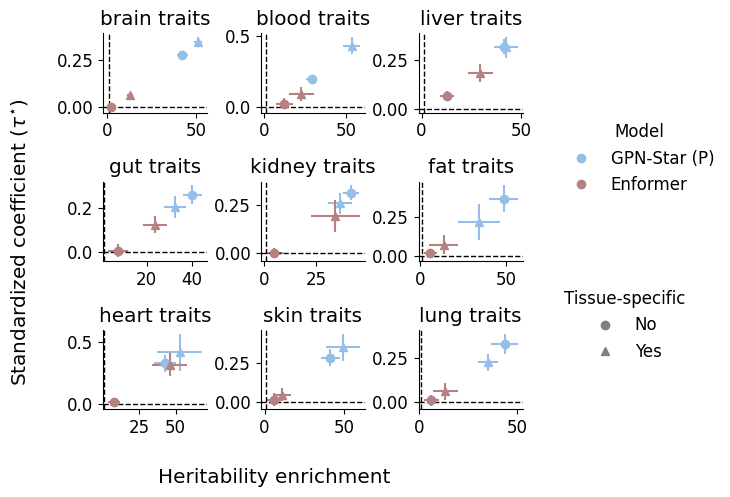

In [55]:
df["tissue"] = pd.Categorical(df["tissue"], categories=tissue_order, ordered=True)
df["model_model"] = pd.Categorical(
    df["model_model"], categories=model_order, ordered=True
)
df = df.sort_values(["tissue", "model_model"])

unique_tissue_specific = ["No", "Yes"]
markers = ["o", "^"]
tissue_specific_markers = dict(
    zip(unique_tissue_specific, markers[: len(unique_tissue_specific)])
)

unique_model_models = df["model_model"].unique()

markersize = None  # 8

# 3. Create the 3x3 subplot grid with shared axes
fig, axes = plt.subplots(3, 3, figsize=(5.5, 5), sharex=False, sharey=False)
axes_flat = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# 4. Loop through each tissue and plot on its corresponding subplot
unique_tissues = df["tissue"].cat.categories.drop_duplicates()
for i, tissue_name in enumerate(unique_tissues):
    if i >= len(axes_flat):
        break  # Stop if we run out of subplots
    ax = axes_flat[i]

    # Filter the dataframe for the current tissue
    tissue_df = df[df["tissue"] == tissue_name]

    # Set subplot titles
    ax.set_title(
        f"{tissue_name} traits",
    )

    # If no data for this tissue, just show title and move on
    if tissue_df.empty:
        continue

    # Plot each point with its error bars, color, and marker style
    for _, row in tissue_df.iterrows():
        ax.errorbar(
            x=row["Enrichment"],
            y=row["tau_star"],
            xerr=row["Enrichment_sd"],
            yerr=row["tau_star_sd"],
            marker=tissue_specific_markers[row["tissue_specific"]],
            fmt="",
            markersize=markersize,
            color=palette[row["model_model"]],
            ecolor=palette[row["model_model"]],
        )

    # Add reference lines
    ax.axvline(x=1, linestyle="--", color="black", linewidth=1)
    ax.axhline(y=0, linestyle="--", color="black", linewidth=1)

# Hide any unused subplots
for i in range(len(unique_tissues), len(axes_flat)):
    axes_flat[i].set_visible(False)

color_legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=model,
        markerfacecolor=palette[model],
        markersize=8,  # markersize=markersize is not working as expected
    )
    for model in unique_model_models
]
legend1 = fig.legend(
    handles=color_legend_elements,
    title="Model",
    loc="center left",
    bbox_to_anchor=(1, 2 / 3),
    frameon=False,
)
marker_legend_elements = [
    Line2D(
        [0],
        [0],
        marker=marker,
        color="grey",
        label=model,
        linestyle="None",
        markersize=markersize,
    )
    for model, marker in tissue_specific_markers.items()
]
fig.legend(
    handles=marker_legend_elements,
    title="Tissue-specific",
    loc="center left",
    bbox_to_anchor=(1, 1 / 3),
    frameon=False,
)
fig.supxlabel("Heritability enrichment")
fig.supylabel(r"Standardized coefficient ($\tau^{\star}$)")
fig.tight_layout()
sns.despine()
plt.savefig(PLOT_DIR + "by_tissue_scatter.pdf", bbox_inches="tight")

In [56]:
subset_tissues = ["brain", "blood", "liver"]
df = df[df.tissue.isin(subset_tissues)]
df

,model,q,approach,Enrichment,Enrichment_sd,Enrichment_p,Coefficient,Coefficient_sd,Coefficient_p,tau_star,tau_star_sd,tau_star_p,Enrichment_p_minuslog10,Coefficient_p_minuslog10,tau_star_p_minuslog10,tissue,model_model,model_tissue,tissue_specific
2,GPN-Star (P)-all,0.001,quantile,42.165751,2.944688,8.294171e-47,5.370873e-07,1.049217e-07,1.536324e-07,0.275097,0.018689,2.417817e-49,46.081227,6.813517,48.616577,brain,GPN-Star (P),all,No
3,GPN-Star (P)-brain,0.001,quantile,50.974892,2.223811,1.391784e-116,8.842187e-07,2.401248e-07,1.155562e-04,0.346518,0.024773,9.227327e-45,115.856428,3.937207,44.034924,brain,GPN-Star (P),brain,Yes
0,Enformer-all,0.001,quantile,2.323014,1.913725,1.123986e-01,5.910011e-09,1.660510e-08,3.609519e-01,0.002994,0.012746,4.071524e-01,0.949239,0.442551,0.390243,brain,Enformer,all,No
1,Enformer-brain,0.001,quantile,12.821629,1.738639,8.246851e-14,7.132806e-08,1.733101e-08,1.930600e-05,0.064614,0.011342,6.100868e-09,13.083712,4.714308,8.214608,brain,Enformer,brain,Yes
2,GPN-Star (P)-all,0.001,quantile,29.230203,3.321598,6.838148e-19,3.308478e-07,1.309693e-07,5.766056e-03,0.196850,0.030122,3.178191e-11,18.165061,2.239121,10.497820,blood,GPN-Star (P),all,No
3,GPN-Star (P)-blood,0.001,quantile,53.499002,5.070085,2.489157e-26,9.594784e-07,2.812347e-07,3.228381e-04,0.430282,0.060101,4.054973e-13,25.603948,3.491015,12.392012,blood,GPN-Star (P),blood,Yes
0,Enformer-all,0.001,quantile,12.461611,5.348597,9.906134e-03,4.031330e-08,7.672956e-08,2.996544e-01,0.023760,0.036721,2.588040e-01,2.004096,0.523379,0.587029,blood,Enformer,all,No
1,Enformer-blood,0.001,quantile,22.710423,7.518475,1.261307e-03,2.739186e-07,1.540516e-07,3.769404e-02,0.092612,0.048097,2.708200e-02,2.899179,1.423727,1.567319,blood,Enformer,blood,Yes
2,GPN-Star (P)-all,0.001,quantile,41.429297,3.735171,6.884402e-29,6.823659e-07,1.608406e-07,1.105235e-05,0.319028,0.037432,7.780784e-18,28.162134,4.956545,17.108977,liver,GPN-Star (P),all,No
3,GPN-Star (P)-liver,0.001,quantile,42.559007,5.952711,4.354192e-13,7.875161e-07,2.028029e-07,5.155387e-05,0.315395,0.053579,1.972155e-09,12.361092,4.287739,8.705059,liver,GPN-Star (P),liver,Yes


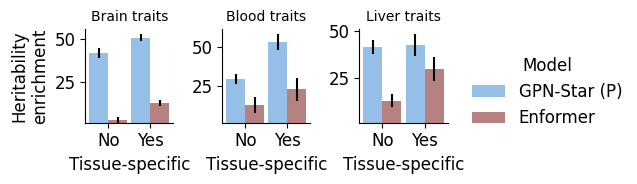

In [57]:
def barplot_with_precomputed_errors(
    data, x, y, hue, y_err, order, hue_order, palette, **kwargs
):
    """
    A custom plotting function that uses matplotlib's bar to plot bars with
    pre-computed error values. This gives us control over the error bars
    while still being usable within seaborn's FacetGrid.map_dataframe.
    """
    ax = plt.gca()

    # Define positions for the bars
    x_categories = order
    hue_categories = hue_order

    n_x_cats = len(x_categories)
    n_hue_cats = len(hue_categories)

    x_indices = np.arange(n_x_cats)
    total_bar_group_width = 0.9
    bar_width = total_bar_group_width / n_hue_cats

    # Plot a set of bars for each hue category (model)
    for j, model in enumerate(hue_categories):
        model_df = data[data[hue] == model]

        # Align data with the x-axis categories
        model_df = model_df.set_index(x).reindex(x_categories)

        enrichment_values = model_df[y]
        enrichment_errors = model_df[y_err]

        # Calculate the centered position for each bar in the group
        bar_positions = (
            x_indices - (total_bar_group_width / 2) + (j * bar_width) + (bar_width / 2)
        )

        ax.bar(
            x=bar_positions,
            height=enrichment_values,
            width=bar_width,
            label=model,
            color=palette.get(model, "gray"),
            yerr=enrichment_errors,
        )

    # Set the x-ticks and labels since we are doing custom plotting
    ax.set_xticks(x_indices)
    ax.set_xticklabels(x_categories)


df["tissue"] = pd.Categorical(df["tissue"], categories=subset_tissues, ordered=True)

# 2. Create a FacetGrid
g = sns.FacetGrid(df, col="tissue", height=2, aspect=0.8, sharey=False, col_wrap=3)

# 3. Map the custom barplot function to the grid
# We pass the column name 'Enrichment_sd' to our custom function via the 'y_err' argument.
g.map_dataframe(
    barplot_with_precomputed_errors,
    x="tissue_specific",
    y="Enrichment",
    y_err="Enrichment_sd",
    hue="model_model",
    palette=palette,
    hue_order=model_order,
    order=["No", "Yes"],
)
g.set(ylim=1)

# 4. Customize each subplot
for ax, title_text in zip(g.axes.flat, g.col_names):
    ax.set_title(f"{title_text.capitalize()} traits", fontsize=10)


# 5. Set overall axis labels and add a legend
g.set_axis_labels("Tissue-specific", "Heritability\nenrichment")
g.add_legend(title="Model")

# 6. Final adjustments
g.tight_layout()
sns.despine()
plt.savefig(PLOT_DIR + "by_tissue_select_bar.svg", bbox_inches="tight")

In [58]:
# should actually think of those matching the specific GTEx tissues
select_tissue_trait = {
    "brain": "Schizophrenia",
    # "blood": "Wbc Count",
    "blood": "Lupus (SLE)",
    # "liver": "Total Bilirubin",
    # "liver": "LDL",
    # "liver": "Type 2 Diabetes",
    # "liver": "Total Protein",
    "liver": "IGF1",
}

select_trait_tissue = {v: k for k, v in select_tissue_trait.items()}
select_traits = select_tissue_trait.values()

In [59]:
df = pd.concat(
    [
        res[
            (res.trait == trait)
            & res.model_tissue.isin(["all", select_trait_tissue[trait]])
        ]
        for trait in select_traits
    ]
)
df["tissue"] = df.trait.map(select_trait_tissue)
df["model_model"] = df.model.str.split("-").str[:-1].str.join("-")
df["tissue_specific"] = (df.model_tissue == df.tissue).map({True: "Yes", False: "No"})
df.rename(
    columns={"Enrichment_std_error": "Enrichment_sd", "tau_star_se": "tau_star_sd"},
    inplace=True,
)
df

,Category,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_sd,Enrichment_p,Coefficient,Coefficient_std_error,Coefficient_z-score,tau_star,tau_star_std_error,trait,model,q,approach,model_tissue,tissue,model_model,tissue_specific
0,L2_1,0.001,0.028991,0.006610,28.991937,6.609759,2.701381e-05,3.456998e-06,9.423354e-07,3.668543,0.235624,0.064228,Schizophrenia,GPN-Star (P)-all,0.001,quantile,all,brain,GPN-Star (P),No
0,L2_1,0.001,0.056846,0.008353,56.847472,8.353105,3.546695e-10,7.370425e-06,1.210347e-06,6.089515,0.485275,0.079690,Schizophrenia,GPN-Star (P)-brain,0.001,quantile,brain,brain,GPN-Star (P),Yes
0,L2_1,0.001,0.001678,0.005888,1.677695,5.888457,9.084522e-01,-7.876414e-08,8.283473e-07,-0.095086,-0.004204,0.044214,Schizophrenia,Enformer-all,0.001,quantile,all,brain,Enformer,No
0,L2_1,0.001,0.007616,0.005970,7.615750,5.970224,2.702949e-01,6.369343e-07,8.327873e-07,0.764822,0.034428,0.045014,Schizophrenia,Enformer-brain,0.001,quantile,brain,brain,Enformer,Yes
0,L2_1,0.001,0.065624,0.035564,65.625282,35.564887,5.221379e-02,4.143191e-06,2.586339e-06,1.601952,0.500947,0.312710,Lupus (SLE),GPN-Star (P)-all,0.001,quantile,all,blood,GPN-Star (P),No
0,L2_1,0.001,0.120006,0.047055,120.009194,47.056696,3.599517e-03,8.294333e-06,3.218382e-06,2.577174,0.986789,0.382896,Lupus (SLE),GPN-Star (P)-blood,0.001,quantile,blood,blood,GPN-Star (P),Yes
0,L2_1,0.001,0.045356,0.036164,45.357626,36.164897,2.195132e-01,2.598030e-06,2.752662e-06,0.943825,0.247918,0.262674,Lupus (SLE),Enformer-all,0.001,quantile,all,blood,Enformer,No
0,L2_1,0.001,0.032497,0.037985,32.497612,37.986480,3.937845e-01,1.376517e-06,2.810532e-06,0.489771,0.130032,0.265496,Lupus (SLE),Enformer-blood,0.001,quantile,blood,blood,Enformer,Yes
0,L2_1,0.001,0.039678,0.007344,39.678785,7.344694,2.280390e-07,1.618381e-06,3.835887e-07,4.219053,0.319594,0.075750,IGF1,GPN-Star (P)-all,0.001,quantile,all,liver,GPN-Star (P),No
0,L2_1,0.001,0.045732,0.008495,45.733128,8.495558,3.625149e-07,1.865430e-06,4.201072e-07,4.440368,0.356887,0.080373,IGF1,GPN-Star (P)-liver,0.001,quantile,liver,liver,GPN-Star (P),Yes


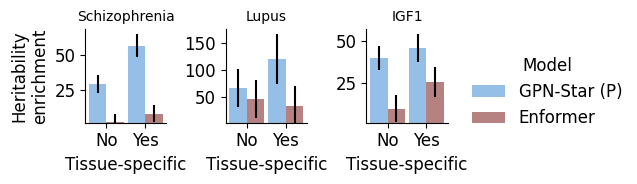

In [60]:
def barplot_with_precomputed_errors(
    data, x, y, hue, y_err, order, hue_order, palette, **kwargs
):
    """
    A custom plotting function that uses matplotlib's bar to plot bars with
    pre-computed error values. This gives us control over the error bars
    while still being usable within seaborn's FacetGrid.map_dataframe.
    """
    ax = plt.gca()

    # Define positions for the bars
    x_categories = order
    hue_categories = hue_order

    n_x_cats = len(x_categories)
    n_hue_cats = len(hue_categories)

    x_indices = np.arange(n_x_cats)
    total_bar_group_width = 0.9
    bar_width = total_bar_group_width / n_hue_cats

    # Plot a set of bars for each hue category (model)
    for j, model in enumerate(hue_categories):
        model_df = data[data[hue] == model]

        # Align data with the x-axis categories
        model_df = model_df.set_index(x).reindex(x_categories)

        enrichment_values = model_df[y]
        enrichment_errors = model_df[y_err]

        # Calculate the centered position for each bar in the group
        bar_positions = (
            x_indices - (total_bar_group_width / 2) + (j * bar_width) + (bar_width / 2)
        )

        ax.bar(
            x=bar_positions,
            height=enrichment_values,
            width=bar_width,
            label=model,
            color=palette.get(model, "gray"),
            yerr=enrichment_errors,
        )

    # Set the x-ticks and labels since we are doing custom plotting
    ax.set_xticks(x_indices)
    ax.set_xticklabels(x_categories)


df["tissue"] = pd.Categorical(df["tissue"], categories=subset_tissues, ordered=True)

# 2. Create a FacetGrid
g = sns.FacetGrid(df, col="tissue", height=2, aspect=0.8, sharey=False)

# 3. Map the custom barplot function to the grid
# We pass the column name 'Enrichment_sd' to our custom function via the 'y_err' argument.
g.map_dataframe(
    barplot_with_precomputed_errors,
    x="tissue_specific",
    y="Enrichment",
    y_err="Enrichment_sd",
    hue="model_model",
    palette=palette,
    hue_order=model_order,
    order=["No", "Yes"],
)
g.set(ylim=1)

# 4. Customize each subplot
for ax, title_text in zip(g.axes.flat, g.col_names):
    trait = df[df["tissue"] == title_text]["trait"].iloc[0]
    if "Lupus" in trait:
        trait = "Lupus"
    ax.set_title(trait, fontsize=10)

# 5. Set overall axis labels and add a legend
g.set_axis_labels("Tissue-specific", "Heritability\nenrichment")
g.add_legend(title="Model")

# 6. Final adjustments
g.tight_layout()
sns.despine()
plt.savefig(PLOT_DIR + "by_trait_select_bar.svg", bbox_inches="tight")

## Part 4 (ablation)

In [61]:
plt.rcParams["font.size"] = 12

In [62]:
res = load_models(
    traits, models_part4, config["quantiles"], ["quantile"], model_renaming_part4
)
res.head()

100%|██████████| 106/106 [00:22<00:00,  4.82it/s]


,Category,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,Coefficient_std_error,Coefficient_z-score,tau_star,tau_star_std_error,trait,model,q,approach
0,L2_1,0.001,0.028991,0.006610,28.991937,6.609759,0.000027,3.456998e-06,9.423354e-07,3.668543,0.235624,0.064228,Schizophrenia,GPN-Star (P243),0.001,quantile
0,L2_1,0.005,0.071546,0.017769,14.309555,3.553885,0.000241,1.267090e-06,5.373023e-07,2.358243,0.184553,0.078259,Schizophrenia,GPN-Star (P243),0.005,quantile
0,L2_1,0.010,0.119548,0.024636,11.954882,2.463604,0.000014,1.028665e-06,3.751196e-07,2.742231,0.206675,0.075367,Schizophrenia,GPN-Star (P243),0.010,quantile
0,L2_1,0.015,0.160364,0.029222,10.691005,1.948160,0.000001,9.270646e-07,3.010913e-07,3.079014,0.223338,0.072536,Schizophrenia,GPN-Star (P243),0.015,quantile
0,L2_1,0.020,0.179633,0.032279,8.981662,1.613945,0.000002,6.876572e-07,2.648119e-07,2.596776,0.187816,0.072327,Schizophrenia,GPN-Star (P243),0.020,quantile


In [63]:
res.model.value_counts()

model
GPN-Star (P243)    1166
GPN-Star (P36)     1166
PhyloP (P243)      1166
PhastCons (P43)    1166
Name: count, dtype: int64

In [64]:
agg_res = run_meta_analysis(res).sort_values("Enrichment", ascending=False)
agg_res["Model"] = agg_res.model
agg_res["Heritability enrichment"] = agg_res["Enrichment"]
agg_res["Heritability enrichment_sd"] = agg_res["Enrichment_sd"]
agg_res.head()

,model,q,approach,Enrichment,Enrichment_sd,Enrichment_p,Coefficient,Coefficient_sd,Coefficient_p,tau_star,tau_star_sd,tau_star_p,Enrichment_p_minuslog10,Coefficient_p_minuslog10,tau_star_p_minuslog10,Model,Heritability enrichment,Heritability enrichment_sd
0,GPN-Star (P243),0.001,quantile,40.147149,1.684172,6.756710e-126,5.131921e-07,5.710067e-08,1.264641e-19,0.286471,0.014219,1.445461e-90,125.170265,18.898033,89.839993,GPN-Star (P243),40.147149,1.684172
11,GPN-Star (P36),0.001,quantile,36.562709,1.449806,1.238503e-140,4.093651e-07,4.532404e-08,8.430823e-20,0.252397,0.012150,3.721214e-96,139.907103,19.074130,95.429315,GPN-Star (P36),36.562709,1.449806
1,GPN-Star (P243),0.005,quantile,23.527657,0.830849,1.049228e-176,2.965286e-07,3.022531e-08,5.067954e-23,0.356193,0.017253,5.424626e-95,175.979130,22.295167,94.265630,GPN-Star (P243),23.527657,0.830849
22,PhastCons (P43),0.001,quantile,22.916398,1.518502,9.217647e-52,1.488102e-07,2.202279e-08,7.039027e-12,0.114043,0.011333,4.038088e-24,51.035380,11.152487,23.393824,PhastCons (P43),22.916398,1.518502
12,GPN-Star (P36),0.005,quantile,21.929511,0.804437,6.203444e-164,2.663517e-07,2.877762e-08,1.066023e-20,0.320926,0.015557,7.578830e-95,163.207367,19.972234,94.120398,GPN-Star (P36),21.929511,0.804437


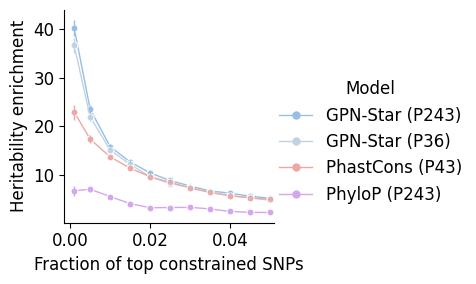

In [65]:
plot_agg_relplot(
    agg_res,
    palette=palette_part4,
    x_label="Fraction of top constrained SNPs",
    y_label="Heritability enrichment",
    values_to_plot=["Heritability enrichment"],
)
plt.savefig(PLOT_DIR + f"fig3_h2_enrich_top0.05_primate36.svg", bbox_inches="tight")

## Supplementary tables

In [66]:
df = trait_tissues[tissue_order].sort_index().replace({True: 1, False: 0})
df

,brain,blood,liver,gut,kidney,fat,heart,skin,lung
ADHD,1,0,0,0,0,0,0,0,0
Abdominal aortic aneurysm,0,0,0,0,0,0,0,0,0
Acne vulgaris,0,0,0,0,0,0,0,1,0
Acute appendicitis,0,0,0,1,0,0,0,0,0
Age First Birth,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
Venous Tromboembolism (VTE),0,0,1,0,0,0,0,0,0
Visceral Adipose Tissue Volume,0,0,0,0,0,1,0,0,0
Vitamin D,0,0,1,0,1,0,0,1,0
WHR BMI ratio,0,0,0,0,0,1,0,0,0


In [67]:
print(df.to_latex(escape=False))

\begin{tabular}{lrrrrrrrrr}
\toprule
 & brain & blood & liver & gut & kidney & fat & heart & skin & lung \\
\midrule
ADHD & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
Abdominal aortic aneurysm & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
Acne vulgaris & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
Acute appendicitis & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
Age First Birth & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
Aging Parental Lifespan & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
Alcohol use/AUDIT & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
Alkaline Phosphatase & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 \\
Alzheimer’s disease & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
Anorexia nervosa & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
Aspartate Aminotransferase & 0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 \\
Asthma & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
Atrial Fibrillation & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
Atrial Fibrillation And Flutter & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
Autism Spectrum Disorder & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
BMI & 1